<a href="https://colab.research.google.com/github/CaoCao-99/Confess_Sugar/blob/main/custom_food_detection_kr(85%2C75)_yolov5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

## Hyperparameters and Constants

Here, we define wether to train the model or not and for how many epochs to train for.

If `TRAIN = False`, then the last trained model will be used for inference in the notebook if run end to end.

In [ ]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 250

## Download and Prepare the Dataset

We will use the <a href="https://public.roboflow.com/object-detection/vehicles-openimages" target="_blank">Vehicles-OpenImages</a> dataset for training the custom YOLOv5 object detector.

Let's download the dataset.

In [ ]:
if not os.path.exists('train'):
    #!curl -L "https://public.roboflow.com/ds/xKLV14HbTF?key=aJzo7msVta" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #!curl -L "https://universe.roboflow.com/ds/FkCakKQO51?key=7MkkYN52Gl" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip -> 5dataset  ['chicken breast', 'gimbap', 'pizza', 'salad', 'tteokbokki']
    !curl -L "https://universe.roboflow.com/ds/rn92UPxxcu?key=RRH9R3fcaU" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    dirs = ['train', 'valid', 'test']

    for i, dir_name in enumerate(dirs):
        all_image_names = sorted(os.listdir(f"{dir_name}/images/"))
        for j, image_name in enumerate(all_image_names):
            if (j % 2) == 0:
                file_name = image_name.split('.jpg')[0]
                os.remove(f"{dir_name}/images/{image_name}")
                os.remove(f"{dir_name}/labels/{file_name}.txt")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: train/images/02_021_02011027_160819795215515_1_jpeg.rf.a7fe28e1cdd8dc9eaf64793d772a0a3e.jpg  
 extracting: train/images/02_021_02011027_160820094612218_0_jpeg.rf.973c45f39e6250e033b10a76cd05e78d.jpg  
 extracting: train/images/02_021_02011027_160820292792738_1_jpg.rf.7965de3d0eb5164e0c10715012b22c73.jpg  
 extracting: train/images/02_021_02011027_160821663467833_1_jpg.rf.78f5a43adac5ef7796e82d6b21ecaf41.jpg  
 extracting: train/images/02_021_02011027_160825117140758_0_jpg.rf.748958fe2e2a61d66468e29146016d23.jpg  
 extracting: train/images/02_021_02011027_160825117140758_1_jpg.rf.bc8fd14ec6ed13f5d16433c5911b2b7a.jpg  
 extracting: train/images/02_021_02011027_160826230791489_0_jpeg.rf.6e1e470df8b6a0397743f6ae8490c539.jpg  
 extracting: train/images/02_021_02011027_160826695097328_0_jpeg.rf.3118c40e5879fddc9a95b365c2975108.jpg  
 extracting: train/images/02_021_02011027_160828086485961_1_jpg.rf.2b7d1a9a8189d64068f674f368ff8a42.jpg  
 extra

The original data had two instances of each image and label file. The rest of the code in the above block deletes the duplicate image and it's corresponding text file containing the label.

The dataset is structured in the following manner:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

## Helper Functions to Download Files

The following function is for downloading any file in the notebook. In further sections of the notebook, we will use it for downloading the inference data.

In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
    else: 
        print('File already present, skipping download...')

### The Dataset YAML File

The dataset YAML (`data.yaml`) file containing the path to the training and validation images and labels is already provided. This file will also contain the class names from the dataset.

The dataset contains 5 classes: **'Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck'**.

The following block shows the contents of the `data.yaml` file.

```yaml
train: ../train/images
val: ../valid/images

nc: 5
names: ['Ambulance', 'Bus', 'Car', 'Motorcycle', 'Truck']
```

%### Visualize a Few Ground Truth Images

Before moving forward, let's check out few of the ground truth images. 

The current annotations in the text files are in normalized `[x_center, y_center, width, height]` format. Let's write a function that will convert it back to `[x_min, y_min, x_max, y_max]` format.

In [ ]:
import yaml
%cd /content

with open('data.yaml') as f:
    vegetables = yaml.load(f, Loader=yaml.FullLoader)
    print(vegetables.get('names'))

/content
['Bibimbap', 'Bulgogi', 'Godeungeogui', 'Jjambbong', 'Ramyun', 'Yangnyumchicken', 'duinjangzzigae', 'gamjatang', 'gimbap', 'jeyukbokum', 'jjajangmyeon', 'kalguksu', 'kimchizzigae', 'mandu', 'pajeon', 'samgyetang', 'samgyubsal', 'sundaegukbap', 'tteokbokki', 'tteokguk']


In [ ]:

class_names = vegetables.get('names')
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [ ]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [ ]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

ValueError: ignored

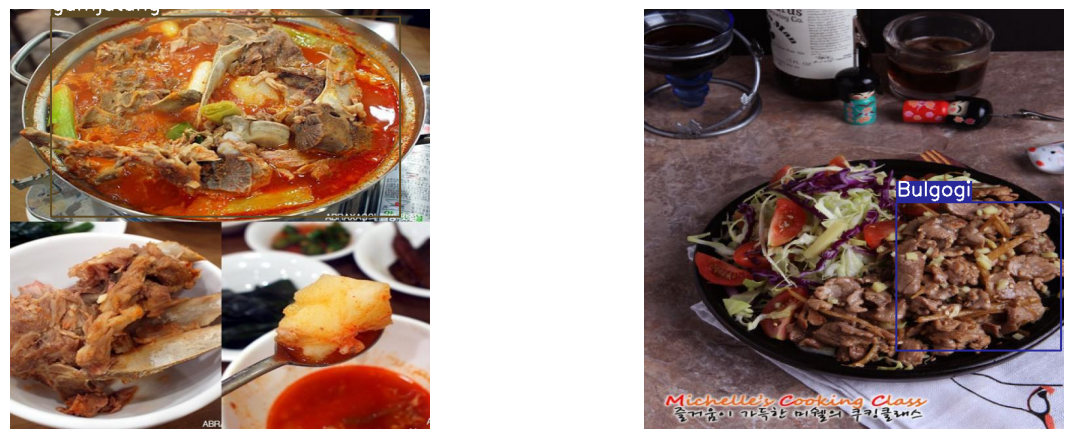

In [ ]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [ ]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [ ]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOV5 Repository

In [ ]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

Cloning into 'yolov5'...
remote: Enumerating objects: 15935, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 15935 (delta 67), reused 75 (delta 52), pack-reused 15831
Receiving objects: 100% (15935/15935), 14.59 MiB | 29.23 MiB/s, done.
Resolving deltas: 100% (10936/10936), done.


In [ ]:
%cd yolov5/
!pwd

/content/yolov5
/content/yolov5


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 593.1/593.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.8 MB/s eta 0:00:00


## Training using YOLOV5

The next step is to train the neural network model.

### Train a Small (yolov5s) Model

Training all the layers of the small model.

In [ ]:
monitor_tensorboard()

NameError: ignored

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5s.pt \
    --img 640 --epochs {EPOCHS} --batch-size 24 --name {RES_DIR}

## Check Out the Validation Predictions and Inference

In this section, we will check out the predictions of the validation images saved during training. Along with that, we will also check out inference of images and videos.

### Visualization and Inference Utilities

We will visualize the validation prediction images that are saved during training. The following is the function for that.

In [ ]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls runs/train/{RES_DIR}
    EXP_PATH = f"runs/train/{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [ ]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights runs/train/{RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR}
    return INFER_DIR

We may also need to visualize images in any of the directories. The following function accepts a directory path and plots all the images in them. 

In [ ]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs/detect/{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

In [ ]:
show_valid_results(RES_DIR)

### Inference
In this section, we will carry out inference on unseen images and videos from the internet. 

The images for inference are in the `inference_images` directory.

The videos for inference are in the `inference_videos` directory.

### Download the Images and Videos
Let's download the images and videos that we will carry inference upon.

### Inference on Images

**To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.**

In [ ]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

In [ ]:
visualize(IMAGE_INFER_DIR)

### Inference on Videos

In [ ]:
inference(RES_DIR, 'inference_videos')

## Training and Inference using  Medium Model

In [ ]:
monitor_tensorboard()

NameError: ignored

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR}

In [ ]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

In [ ]:
visualize(IMAGE_INFER_DIR)

In [ ]:
inference(RES_DIR, 'inference_videos')

## Freezing Layers and Training the Medium Model

The Medium model (yolov5m) contains 25 blocks layers in total more than 20 million parameters. We need not train all the layers. Let's freeze a few layers and train again. This will result in faster iteration per epoch. Here, we freeze the first 15 blocks.

In [ ]:
monitor_tensorboard()

In [ ]:
RES_DIR = set_res_dir()
if TRAIN:
    !python train.py --data ../data.yaml --weights yolov5m.pt \
    --img 640 --epochs {EPOCHS} --batch-size 16 --name {RES_DIR} \
    --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

In [ ]:
# Inference on images.
IMAGE_INFER_DIR = inference(RES_DIR, 'inference_images')

In [ ]:
visualize(IMAGE_INFER_DIR)

In [ ]:
inference(RES_DIR, 'inference_videos')